# 1. Overview
In Machine Learning, there are commonly two problems (functions) that need to be optimized:

$$\begin{aligned}
f &:\text{parameter}\rightarrow\text{loss} \\
f &:\text{hyperparameter}\rightarrow\text{score}
\end{aligned}$$

The first problem is nothing but the training/fitting step; the loss function $\mathcal{L}$ to be minimized is known and more importantly, *differentiable*. Therefore, a gradient-based method such as Gradient Descent can be used to estimate model parameters.

The second one (also known as hyperparameter tuning) does not have a mathematical form and thus cannot be solved using Gradient Descent. The optimal set of hyperparameters is usually found either by Data Scientists using rule of thumb or by searching methods. However, each trial is expensive and we must find the optimal configurations with as few trials as possible.

Scoring strategies in Machine Learning can be either *higher is better* (R2, AUC, F1,...) or *lower is better* (RMSE, MAE,...). To make things consistant, we assume all evaluation metrics are higher better.

## 1.1. Exhausted search
There are two popular methods of searching hyperparameters, implemented in Scikit-learn via the classes
<code style='font-size:13px'><a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html'>GridSearchCV</a></code>
and
<code style='font-size:13px'><a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html'>RandomizedSearchCV</a></code>.
The idea of each method are already explained clearly in the image below, where the red area shows how much each hyperparameter contributes to model score.

<img src='image/grid_random_search.png' style='width:450px; margin:20px auto;'>

Grid Search goes to every possible combinations, and thus it will revisit a parameter value multiple times. This makes Grid Search have a low coverage and is very expensive, especially for algorithms with a huge number of hyperparameters such as XGBoost and LightGBM.

Random Search is a more efficient method, it randomly takes a number combinations to train models. With the same number of iterations provided, Random Search can cover a wider range of values, and thus it is able to reach the optimal value that Grid Search cannot. Another advantage is that you can include unimportant hyperparameters in your search without increasing the number of trials.

## 1.2. Sequential search
It's not difficult to see that searching methods perform expensive trials independently, thus they are actually wasting a lot of useful information from previous trials. In order to take advantages of historical information, SMBO (**S**equential **M**odel-**B**ased **O**ptimization) comes to the rescue. This is a class contains algorithms that *smartly* predict the most promising configuration *sequentially*, thus reduce the number of training rounds needed significantly.

The basic idea of SMBO is to build a *probabilistic surrogate model* of the black-box function $f:\text{hyperparameter}\rightarrow\text{score}$ using results from observed trials. You can think of it as Machine Learning of Machine Learning; this concept can be a bit complicated but is exactly how it works. There are many algorithms using this sequential search strategy, but in this topic, we are discussing Bayesian Optimization and Tree-structured Parzen Estimators.

## 1.3. Bandit-based
Another effective strategy is using [Multi-Armed Bandit](<https://en.wikipedia.org/wiki/Multi-armed_bandit>). This method is all about *resources allocation*, which smartly uses the most resources on the most promising hyperparameters sets. Multi-Armed Bandit fits so well for Machine Learning algorithms with iterative training behavior, as number of estimators in Gradient Boosting and number of epochs in Deep Learning may serve as the role of resources.

A well-known algorithm of this family is Successive Halving, which is implemented in Scikit-learn via
<code style='font-size:13px'><a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html'>HalvingGridSearchCV</a></code> and
<code style='font-size:13px'><a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html'>HalvingRandomSearchCV</a></code>.
There are also improved variants HyperBand and BOHB (a combination of Bayes Optimization and HyperBand).

## 1.4. Evolutionary
Evolutionary algorithms are inspired from [natural selection](https://en.wikipedia.org/wiki/Natural_selection) treat each hyperparameter as a gene and iteratively discard candidates with bad genes. Only good genes are kept in order to perform random permutations on.

# 2. Bayesian Optimization
A SMBO using Gaussian Process as the surrogate function is called **B**ayesian **O**ptimization (BO), since Gaussian Process use Bayes' rule to update the posterior distribution. This is the most popular algorithm for hyperparameter tuning that is implemented in many packages such as
[bayes_opt](https://github.com/fmfn/BayesianOptimization),
[scikit-optimize](https://github.com/scikit-optimize/scikit-optimize),
[nni](https://github.com/microsoft/nni),
[spearmint](https://github.com/JasperSnoek/spearmint),
[pyGPGO](https://github.com/josejimenezluna/pyGPGO),
[MOE](https://github.com/Yelp/MOE),
[GPyOpt](https://github.com/SheffieldML/GPyOpt).
Despite that, the algorithm has some disadvantages:
- It does not support categorical hyperparameters, such as impurity criterion in Decision Tree.
- Gaussian Process does not scale very well

## 2.1. Algorithm
*Input*:
- A domain, or search space of hyperparameters
- $f$, the black-box function to be optimized, it maps hyperpameters to model score: $y=f(x)$ and is very expensive to evaluate
- $T$, the number of trials budget
- $\mathcal{S}$, a surrogate model (Gaussian Process) which takes finished trials as input then returns a distribution of model score for each unobserved trial
- $\mathcal{A}$, an acquisition function for deciding where the next trial should locate at

*Step 1*: Create a set $\mathcal{H}$ for storing historical trials $(x,y)$ with a randomly initialized trial $(x_0,y_0)$.

*Step 2*: For each trial $t$ for $t=1,2,\dots,T$:
- Fit the surrogate model on $\mathcal{H}$ to get $\mathcal{S}_t$
- Compute the acquisition function $\mathcal{A}_t(x)$ using $\mathcal{S}_t$ and $\mathcal{H}$
- Evaluate the most promising query point $x_t=\arg\max\mathcal{A}_t(x)$
- Train the expensive Machine Learning model using hyperparameters $x_t$ and compute its score $y_t=f(x_t)$
- Append the result $(x_t,y_t)$ to $\mathcal{H}$

## 2.2. Acquisition functions
Acquisition function is a very important component of SMBO, it defines the strategy to select the next set of hyperparameters to be used in training Machine Learning model. Acqusition functions control the balance between *exploitation* and *exploration*. In this section, we learn about 4 most popular options, using these notations:
- $x^\star,y^\star$ are the best hyperparameters so far in $\mathcal{H}$ and the associated model score
- $\varphi(\cdot)$ and $\psi(\cdot)$ indicate the PDF and CDF, respectively
- $\mu_y$ and $\sigma_y$ indicate the mean and standard deviation of model score according to the surrogate model

<img src='image/acquisition_functions.png' style='height:450px; margin:20px auto 20px;'>

### Probability of Improvement
The idea of PI is very simple, it measures, at each unused configuration $x$, the probability that the corresponding score $y$ is higher than the current best score $y^\star$. A small positive offset $\xi$ is added to maintain the trade-off between *exploration* and *exploitation*.

$$\text{PI}=\text{Prob }(y>y^\star+\xi)$$

The intuition behind $\xi$ is all about *uncertainty*. For certain areas, the distribution of model scores are clustered around the mean, so that only a small $\xi$ penalizes their PI a lot. For this reason, higher values of $\xi$ favor exploration; but if too high, the behaviour will be a lot like [Active Learning](<https://en.wikipedia.org/wiki/Active_learning_(machine_learning)>). A balanced $\epsilon$ will make SMBO explore *just enough* and spend trials effectively on exploitation.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt; plt.style.use(['seaborn', 'seaborn-whitegrid'])
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
%config InlineBackend.figure_format = 'retina'

In [2]:
f = lambda x: 0.009*x**5 + 0.06*x**4 - 0.03*x**3 - 0.72*x**2 - 0.75*x + 1.8

np.random.seed(7)
xTrain = np.array([-4, 0.5, 1.5, 3])
yTrain = f(xTrain)

xTest = np.linspace(-5, 3.5, 100)
yTest = f(xTest)

In [3]:
algo = GaussianProcessRegressor()
model = algo.fit(xTrain.reshape(-1,1), yTrain)
meanPred, sigmaPred = model.predict(xTest.reshape(-1,1), return_std=True)
lower, upper = meanPred - sigmaPred, meanPred + sigmaPred

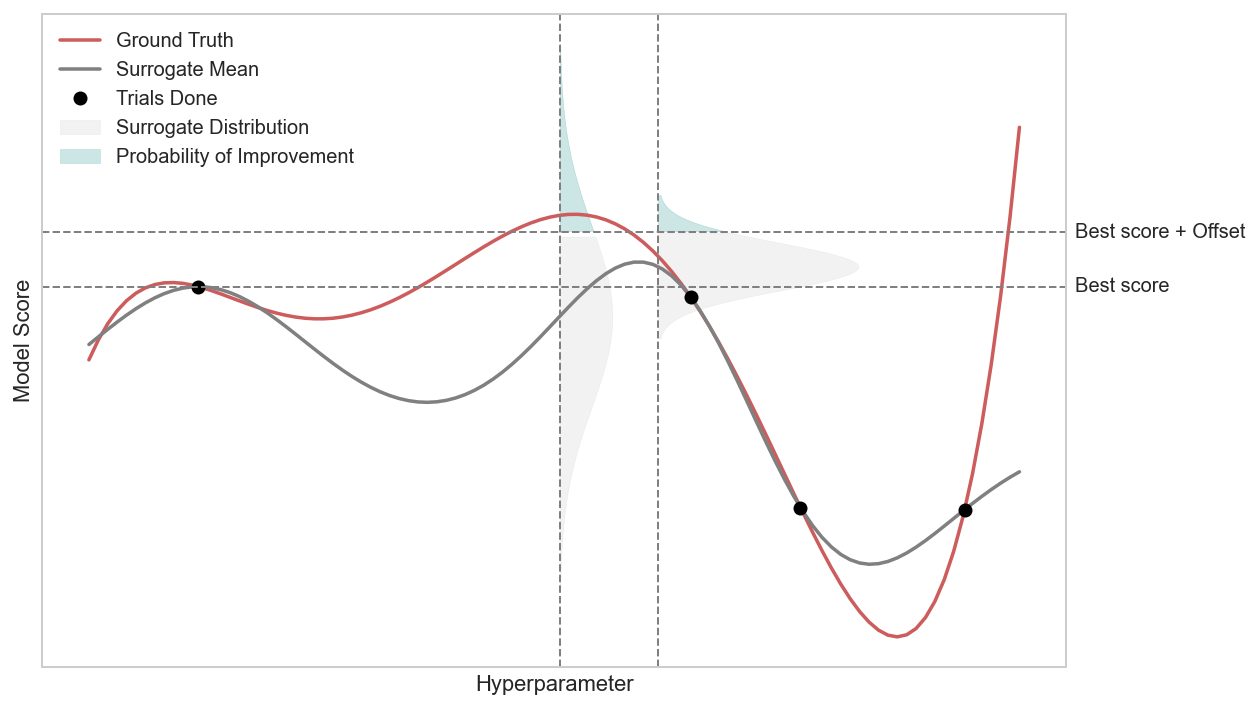

In [5]:
xi = 0.5
yStar = yTrain.max()
yThres = yStar + xi

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(xTest, yTest, 'indianred', label='Ground Truth')
ax.plot(xTest, meanPred, color='grey', label='Surrogate Mean')
ax.plot(xTrain, yTrain, 'ok', label='Trials Done')

ax.axhline(yTrain.max(), ls='--', lw=1, c='grey')
ax.axhline(yTrain.max()+xi, ls='--', lw=1, c='grey')

yStar = yTrain.max()
yThres = yStar + xi
ax.text(ax.get_xlim()[1]*1.02, yStar, 'Best score', va='center', ha='left')
ax.text(ax.get_xlim()[1]*1.02, yThres, 'Best score + Offset', va='center', ha='left')

for idx, xQuery in enumerate([-0.7, 0.2]):
    xQuery = np.array(xQuery)
    muQuery, sigmaQuery = model.predict(xQuery.reshape(-1,1), return_std=True)
    muQuery, sigmaQuery = muQuery[0], sigmaQuery[0]
    distQuery = stats.norm(muQuery, sigmaQuery)
    lowerQuery, upperQuery = muQuery - 3*sigmaQuery, muQuery + 3*sigmaQuery
    yRange = np.linspace(lowerQuery, upperQuery, 100)
    yPlot = yRange[yRange < yThres]
    xPlot = xQuery + distQuery.pdf(yPlot)
    yPI = yRange[yRange >= yThres]
    xPI = xQuery + distQuery.pdf(yPI)
    
    ax.axvline(xQuery, ls='--', lw=1, c='grey')
    if idx == 0:
        ax.fill_betweenx(yPlot, xPlot, xQuery, color='grey', alpha=0.1, label='Surrogate Distribution')
        ax.fill_betweenx(yPI, xPI, xQuery, color='teal', alpha=0.2, label='Probability of Improvement')
    else:
        ax.fill_betweenx(yPlot, xPlot, xQuery, color='grey', alpha=0.1)
        ax.fill_betweenx(yPI, xPI, xQuery, color='teal', alpha=0.2)
        

ax.axis('scaled')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()
ax.grid(False)
ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('Model Score')
plt.show()

### Expected Improvement
As PI only considers *how likely* to improve, we need EI to answer *how much* the improvement can be. We simply measure the [expected value](https://en.wikipedia.org/wiki/Expected_value#Random_variables_with_density) of improvement $y-y^\star$, or more percisely, $\max(y-y^\star-\xi,0)$. In the later formula, we are clipping negative improvements at zero. An offset $\xi$ is also added with the same intuition as in Probability of Improvement.

$$\text{EI}=\int_{-\infty}^{\infty} {(y-y^\star-\xi)\,\varphi(y)\,\text{d}y}$$

As EI and PI overcome the limitation of the other, we can combine them: $\text{PI}+\lambda\text{EI}$ to get a new acquisition function, PI-EI.

### Upper Confidence Bound
This acquisition function is a linear combination of the surrogate mean $\mu_y$ and the surrogate uncertainty $\sigma_y$. A multiplier $\kappa$ is attached to $\sigma_y$, it also favors *exploration*.

$$\text{UCB}=\mu_y+\kappa\sigma_y$$

### Thomson Sampling
As its name states, this method randomly samples a function that follows the surrogate distribution at each trial. Such a stochastic behaviour is non-deterministic in short-term but can converge in long-term as it is naturally exploration-exploitation balance.

## 2.3. Implementation: Bayes-opt
In this section, we are going to use Bayes_opt and start simple with an example of maximizing the function:

$$f(x,y,z)=100-(x-1)^2+-(y-2)^2+-(z-4)^2$$

This problem can be easily solved by hand: $\max{f}=100$ and $\arg\max{f}=(1,2,4)$. Let's see how BO performs in action. Before we start, always remember that $f$ is an *expensive black box* function.

In [1]:
f = lambda x, y, z: 100 - (x-1)**2 - (y-2)**2 - (z-4)**2 

In [2]:
from bayes_opt import BayesianOptimization
space = {
    'x': (-5, 5),
    'y': (-5, 5),
    'z': (-5, 5),
}

In [3]:
optimizer = BayesianOptimization(f=f, pbounds=space, verbose=2, random_state=1)
optimizer.maximize(init_points=3, n_iter=12, acq='ucb', kappa=2.5)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  15.63    | -0.8298   |  2.203    | -4.999    |
|  2        | -4.7      | -1.977    | -3.532    | -4.077    |
|  3        |  44.99    | -3.137    | -1.544    | -1.032    |
|  4        |  44.6     | -3.174    | -1.831    | -0.8263   |
|  5        |  60.98    | -4.083    |  0.04953  |  0.9382   |
|  6        |  96.31    | -0.7705   |  1.273    |  4.159    |
|  7        |  88.2     |  2.343    |  5.0      |  5.0      |
|  8        |  74.54    |  5.0      | -0.9091   |  5.0      |
|  9        |  65.17    | -4.065    |  4.859    |  4.997    |
|  10       |  65.21    |  5.0      |  5.0      |  0.8713   |
|  11       |  75.69    | -0.1365   | -2.693    |  5.0      |
|  12       |  98.32    |  1.742    |  1.648    |  5.0      |
|  13       |  97.98    |  1.017    |  2.303    |  2.61     |
|  14       |  97.51    |  0.1922   |  3.312    |  4.336    |
|  15   

In [4]:
optimizer = BayesianOptimization(f=f, pbounds=space, verbose=2, random_state=1)
optimizer.maximize(init_points=3, n_iter=12, acq='poi', xi=0.1)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  15.63    | -0.8298   |  2.203    | -4.999    |
|  2        | -4.7      | -1.977    | -3.532    | -4.077    |
|  3        |  44.99    | -3.137    | -1.544    | -1.032    |
|  4        |  44.6     | -3.174    | -1.831    | -0.8263   |
|  5        |  46.11    | -3.181    | -1.498    | -0.9167   |
|  6        |  47.26    | -3.226    | -1.44     | -0.8012   |
|  7        |  49.7     | -3.268    | -1.196    | -0.6767   |
|  8        |  51.54    | -3.256    | -0.9533   | -0.6504   |
|  9        |  56.67    | -3.249    | -0.4196   | -0.4069   |
|  10       |  61.06    | -3.223    |  0.05349  | -0.1613   |
|  11       |  64.22    | -3.264    |  0.3143   |  0.1591   |
|  12       |  65.4     | -3.265    |  0.4904   |  0.2406   |
|  13       |  68.15    | -3.36     |  1.046    |  0.5464   |
|  14       |  68.66    | -3.398    |  1.171    |  0.6378   |
|  15   

In [63]:
optimizer = BayesianOptimization(f=f, pbounds=space, verbose=2, random_state=1)
optimizer.maximize(init_points=3, n_iter=12, acq='ei', xi=0.1)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  15.63    | -0.8298   |  2.203    | -4.999    |
|  2        | -4.7      | -1.977    | -3.532    | -4.077    |
|  3        |  44.99    | -3.137    | -1.544    | -1.032    |
|  4        |  44.6     | -3.174    | -1.831    | -0.8263   |
|  5        |  56.05    | -3.631    | -0.6719   |  0.08012  |
|  6        |  55.63    | -5.0      |  1.158    |  1.232    |
|  7        |  87.19    | -2.018    |  0.7071   |  2.576    |
|  8        |  97.13    | -0.4664   |  1.16     |  4.134    |
|  9        |  94.88    |  0.8402   |  4.186    |  4.563    |
|  10       |  90.31    |  3.888    |  1.41     |  5.0      |
|  11       |  99.28    |  1.074    |  2.031    |  3.156    |
|  12       |  72.4     |  5.0      |  5.0      |  2.388    |
|  13       |  34.0     |  5.0      | -5.0      |  5.0      |
|  14       |  99.68    |  1.162    |  2.185    |  4.505    |
|  15   

In [64]:
optimizer.max

{'target': 99.68468719711005,
 'params': {'x': 1.1623018678779808,
  'y': 2.185370504483861,
  'z': 4.504587636234444}}

Now, analyze the results of Bayesian Optimization with different acquisition functions. Each candidate is provided 15 trials in total in which the 3 first rounds are random initialization with the same random seed. The current best scores are in purple.
- First candidate: UCB with $\kappa=3$. Although the alogrithm has explored a very high score quite early ($y=96.31$ at iteration #6) and another high score later ($y=98.32$ at iteration #12), it keeps exploring the range $[96.31,98.32]$. Our algorithm seems explores more than needed and forget to exploit, thus it cannot beat $98.32$. Another thing can be observed is that these two high scores are found quite *luckily*.
- Second candidate: PI with $\xi=0.1$. This algorithm doesn't take risks and refuses to explore. Once it finds a way that can improve score, it keeps going towards that direction but very slowly. It's afraid of losing that path.
- Third candidate: EI with $\xi=0.1$, the best candidate, not because EI is better but because exploration-exploitation in this case is balanced. This algorithm also follows the same path with PI, but completes it very quickly after only 5 rounds. It then spends some trials exploring uncertain areas, but right after being sure they are not promising, the algorithm switches back to exploitation mode and finishes at $y=99.68$.

## 2.4. Implementation: Scikit-optimize
[Scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) is another library that implements Bayesian Optimization. It is built on top of Scikit-learn and thus provides a familiar interface with Data Scientists.

In [5]:
import datetime as dt
import numpy as np; np.set_printoptions(precision=4, suppress=True)
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as R2

from skopt import Optimizer, BayesSearchCV
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space.space import Real, Integer, Categorical, Dimension
from skopt.utils import use_named_args

In [6]:
dfBoston = pd.read_csv('data/boston.csv')
dfBoston.head()

,crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
x = dfBoston.copy()
y = x.pop('price')
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/10, random_state=7)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/9, random_state=7)

### BayesSearchCV

In [8]:
searchSpace = {
    'n_estimators': Integer(50, 300),
    'learning_rate': Real(0.01, 0.5),
    'reg_alpha': Real(1e-5, 1e5, prior='log-uniform', base=10),
    'boosting_type': Categorical(['gbdt', 'goss', 'dart']),
}

In [9]:
start = dt.datetime.now()

algo = LGBMRegressor()
validator = BayesSearchCV(algo, searchSpace, cv=5, scoring='r2', n_iter=20)
validator = validator.fit(xTrain, yTrain)
model = validator.best_estimator_

end = dt.datetime.now()
print(end - start)

0:00:22.594505


In [10]:
validator.best_params_

OrderedDict([('boosting_type', 'dart'),
             ('learning_rate', 0.44286614584030554),
             ('n_estimators', 128),
             ('reg_alpha', 0.0030414870639248457)])

In [11]:
yTestPred = model.predict(xTest)
r2Test = R2(yTest, yTestPred)
modelName = model.__class__.__name__

print(f'R2 = {r2Test:.4f} [{modelName}]')

R2 = 0.8860 [LGBMRegressor]


### Low-level interface

In [12]:
searchSpace = [
    Integer(50, 300, name='n_estimators'),
    Real(0.01, 0.5, name='learning_rate'),
    Real(1e-5, 1e5, prior='log-uniform', base=10, name='reg_alpha'),
    Categorical(['gbdt', 'goss', 'dart'], name='boosting_type'),
]

In [13]:
@use_named_args(searchSpace)
def model_score(**params):
    model = LGBMRegressor(**params)
    model.fit(xTrain, yTrain)
    yValidPred = model.predict(xValid)
    r2Valid = R2(yValid, yValidPred)
    return - r2Valid

searchResult = gp_minimize(model_score, searchSpace, n_calls=20, n_initial_points=5)

In [14]:
searchResult.x

[232, 0.390552436302625, 0.0003471326146338028, 'gbdt']

In [15]:
searchResult.fun

-0.900411530385728

In [16]:
df = pd.DataFrame(
    data=searchResult.x_iters[:5],
    index=''
)

[[232, 0.390552436302625, 0.0003471326146338028, 'gbdt'],
 [132, 0.2619994811875118, 80.82225265683698, 'goss'],
 [99, 0.4816407488117391, 31.403865748829578, 'gbdt'],
 [174, 0.3439422705326614, 0.5970108141078779, 'goss'],
 [56, 0.157251760215045, 29.99491541464815, 'gbdt']]

In [17]:
searchResult.func_vals[:5]

array([-0.9004, -0.8235, -0.8635, -0.8508, -0.8616])

# 3. Parzen Estimators
Parzen-window Estimation is another name of [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) which is usually included in histograms. **T**ree-structured **P**arzen **E**stimators (TPE) is an algorithm of SMBO family and is proposed in the same paper with BO. TPE estimates the likelihood $\text{Pr }(x|y)$ rather than the posterior $\text{Pr }(y|x)$ as in BO.

## 3.1. Algorithm
*Input*:
- A domain, or search space of hyperparameters
- $f$, the black-box function to be optimized, it maps hyperpameters to model score: $y=f(x)$ and is very expensive to evaluate
- $T$, the number of trials budget

*Step 1*: Warm up several trials using Random Search. The observed scores are splited into two groups: low and high score, denoted $\mathcal{L}$ and $\mathcal{H}$. The high score group is usually 10-25% number of observed trials.

*Step 2*: Construct KDEs for low-score and high-score groups. They serve as surrogate models representing the likelihoods $\text{Pr }(x|y\in\mathcal{L})$ and $\text{Pr }(x|y\in\mathcal{H})$, respectively. We would probably want our next trial is more likely to be in $\mathcal{H}$ and less likely to be in $\mathcal{L}$.

*Step 3*: Select the acqusition function: $\mathcal{A}(x)=\text{Pr }(x|y\in\mathcal{H})\div\text{Pr }(x|y\in\mathcal{L})$. Selecting $x=\arg\max\mathcal{A}(x)$ ends up getting the same result as maximizing EI in Bayesian Optimization, but this method considers the *top best trials* rather than only the best trial. Repeat step 2 and 3 until the budget $T$ elapses.

<img src='image/tpe.png' style='height:450px; margin:20px auto 20px;'>

## 3.2. Implementation: Hyperopt
In this section we are going to use [Hyperopt](https://github.com/hyperopt/hyperopt), a low-level but powerful implementation of TPE.

In [7]:
import numpy as np; np.set_printoptions(precision=4, suppress=True)
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as R2

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVC, SVR

from hyperopt import hp, fmin, rand, tpe, Trials
from hyperopt.pyll import scope

In [20]:
dfBoston = pd.read_csv('data/boston.csv')
dfBoston.head()

,crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [21]:
x = dfBoston.copy()
y = x.pop('price')
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/10, random_state=7)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/9, random_state=7)

### Basic usage
The use of <code style='font-size:13px'>fmin()</code>, the most important function of Hyperopt, along with the <code style='font-size:13px'>hp</code> submodule for defining hyperparameter distributions.

In [22]:
black_box_func = lambda x, y, z: 100 - (x-1)**2 - (y-2)**2 - (z-4)**2

def fn(params):
    return - black_box_func(**params)

searchSpace = {
    'x': hp.uniform('x', low=-5, high=5),
    'y': hp.choice('y', options=[0, 1, 2, 3, 4]),
    'z': hp.loguniform('z', low=0, high=5),
}

In [23]:
trials = Trials()
fmin(
    fn=fn,
    space=searchSpace,
    max_evals=50,
    algo=tpe.suggest,
    trials=trials,
    rstate=np.random.seed(7)
)

100%|██████████| 50/50 [00:00<00:00, 245.48trial/s, best loss: -98.995812702584]


{'x': 1.060761427151827, 'y': 1, 'z': 3.977743621443048}

In [24]:
df = pd.DataFrame(trials.vals)
df['func'] = trials.losses()
df = df.round(3).sort_values('func')
df.head()

,x,y,z,func
1,1.061,1,3.978,-98.996
23,1.853,1,3.693,-98.178
24,2.032,1,3.865,-97.917
45,-0.420,2,3.699,-97.893
6,0.568,3,3.011,-97.834


### Validation
Let's uses <code style='font-size:13px'>fmin()</code> and <code style='font-size:13px'>hp</code> to optimize hyperparameters of SVM.

In [10]:
def holdout_tuning(params):
    model = SVR(**params)
    model.fit(xTrain, yTrain)
    yValidPred = model.predict(xValid)
    r2Valid = R2(yValid, yValidPred)
    return - r2Valid

def crossval_tuning(params):
    algo = SVR(**params)
    r2Valid = cross_val_score(algo, xTrain, yTrain, scoring='r2', cv=5).mean()
    return - r2Valid

searchSpace = {
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'degree': hp.quniform('degree', low=1, high=7, q=1),
    'C': hp.loguniform('C', low=-5, high=5),
}

In [11]:
trials = Trials()
fmin(
    fn=holdout_tuning,
    space=searchSpace,
    max_evals=20,
    algo=tpe.suggest,
)

100%|███████████████████████████████████████████████| 20/20 [00:50<00:00,  2.53s/trial, best loss: -0.6492170817703494]


{'C': 54.088782020579494, 'degree': 7.0, 'kernel': 0}

In [44]:
trials = Trials()
fmin(
    fn=crossval_tuning,
    space=searchSpace,
    max_evals=20,
    algo=tpe.suggest,
)

100%|███████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09trial/s, best loss: -0.7012666183746514]


{'C': 0.2875113193925223, 'degree': 3.0, 'kernel': 0}

### Model selection
Things get more complicated: we need to choose between several algorithms with their own search spaces. Hyperopt tackles this by allowing classifiers/regressors using Scikit-learn API to be registered to Hyperopt's scope, so that they c

In [8]:
for estimator in (XGBRegressor, LGBMRegressor, CatBoostRegressor):
    try: scope.define(estimator)
    except: pass

spaceXGBoost = scope.XGBRegressor(
    n_estimators=hp.randint('xgb_nEstimators', 1000),
    learning_rate=hp.uniform('xgb_learningRate', 0.001, 0.5),
    grow_policy=hp.choice('xgb_growPolicy', ['lossguide', 'depthwise']),
    reg_alpha=hp.loguniform('xgb_regL1', -5, 5),
    reg_lambda=hp.loguniform('xgb_regL2', -5, 5),
    num_leaves=hp.choice('xgb_maxLeaves', [4, 8, 16, 32, 64]),
    colsample_bytree=hp.uniform('xgb_fracFeatureByTree', 0.2, 0.8),
    colsample_bylevel=hp.uniform('xgb_fracFeatureByLevel', 0.2, 0.8),
    colsample_bynode=hp.uniform('xgb_fracFeatureByNode', 0.2, 0.8),
    subsample=hp.uniform('xgb_fracSample', 0.2, 0.8),
    verbosity=0, silent=1,
)

spaceLightGBM = scope.LGBMRegressor(
    n_estimators=hp.randint('lgb_nEstimators', 1000),
    learning_rate=hp.uniform('lgb_learningRate', 0.001, 0.5),
    boosting_type=hp.choice('lgb_booster', ['gbdt', 'goss', 'dart']),
    subsample=hp.uniform('lgb_fracSample', 0.2, 0.8),
    colsample_bytree=hp.uniform('lgb_fracFeature', 0.2, 0.8),
    num_leaves=hp.choice('lgb_maxLeaves', [4, 8, 16, 32, 64]),
    reg_alpha=hp.loguniform('lgb_regL1', -5, 5),
    reg_lambda=hp.loguniform('lgb_regL2', -5, 5),
    verbosity=-1,
)

spaceCatBoost = scope.CatBoostRegressor(
    n_estimators=hp.randint('cgb_nEstimators', 1000),
    learning_rate=hp.uniform('cgb_learningRate', 0.001, 0.5),
    l2_leaf_reg=hp.loguniform('cgb_regL2', -5, 5),
    subsample=hp.uniform('cgb_fracSample', 0.2, 0.8),
    boosting_type='Ordered',
    grow_policy='SymmetricTree',
    verbose=0,
)

searchSpace = hp.choice('clf', [spaceXGBoost, spaceLightGBM, spaceCatBoost])

In [6]:
def score_model(estimator):
    estimator.fit(xTrain, yTrain)
    yValidPred = estimator.predict(xValid)
    r2Valid = R2(yValid, yValidPred)
    return - r2Valid

In [9]:
fmin(
    fn=score_model,
    space=searchSpace,
    max_evals=200,
    algo=tpe.suggest,
)

100%|█████████████████████████████████████████████| 200/200 [09:25<00:00,  2.83s/trial, best loss: -0.9404563285976195]


{'cgb_fracSample': 0.7670114374279781,
 'cgb_learningRate': 0.04852071907043586,
 'cgb_nEstimators': 535,
 'cgb_regL2': 0.01292892425132965,
 'clf': 2}

# 4. Hyperband

## 4.1. Successive Halving

### Resource allocation
As Multi-Armed Bandits algorithms are all about *resources allocation*, we need to define *resource*. In the context of Machine Learning, it should be the something (1) measurable, prefered in integer, (2) proportional to training time and (3) can be added partially to the model without re-training from the start.

For all Machine Learning algorithms, the number of samples is a viable choice, but it only satisfies (1) and (2). Fortunately, most state-of-the-art algorithms (Gradient Boosting for strutured data and Neural Network for nonstructured data) use a Stochastic Gradient Descent mechanism for model training, which statisfies all (1), (2) and (3). Thanks to this online learning behaviour, we can use, for example, number of trees in XGBoost or number of epochs in MLP as *resource*. We denote $B$ the maximum budget for the selected resource.

### Algorithm
Successive Halving uniformally allocates the budget to $N$ configurations randomly choosed from the hyperparameter space, which means each configuration is trained using $\lfloor B/N\rfloor$ whatever the resource is. The bottom half in terms of validation score is discarded (early stopping), while the top half is promoted to the next bracket and then trained with doubled resources. This process is repeated until one configuration survives.

The algorithm can be generalized to:
- Instead of strictly *halving*, we perform *eliminating* with an *elimination rate*, $\eta\geq2$, so that in each bracket we promote only $1/\eta$ best scoring candidates and give them resources $\eta$ times higher than the last round.
- Use any number of resources in the first bracket instead of fixing the value to be $\lfloor B/N\rfloor$.

*Example*: Let's say we are tuning an XGBoost model with $B=200$ trees. Successive Halving with $N=32$ and $\eta=2$ is demonstrated in the table below:

||Candidates survived|Number of trees|
|:---|:---:|---:|
|Bracket 1|$32$|$\lfloor 200\div32\rfloor=6$|
|Bracket 2|$16$|$6\times2=12$|
|Bracket 3|$8$|$12\times2=24$|
|Bracket 4|$4$|$24\times2=48$|
|Bracket 5|$2$|$48\times2=96$|
|Bracket 6|$1$|$96\times2=192$|

## 4.2. Hyperband
Hyperband is an improved version solving the problem *$N$ versus $B/N$* that Successive Halving suffers from.

### N versus B/N problem
This problem is all about *biases*, especially in early rounds: a good candidate can poorly perform if not being given enough resources. You can look at the learning curve of Gradient Boosting or Gradient Descent examples in practice to see a particular situation: the curve first fluctuates very much, but when the number of epochs/trees increases, it converges to a stable state.

<img src='image/learning_curve_fluctuations.png' style='height:250px; margin:20px auto 20px;'>

In the $N$ versus $B/N$ problem, $N$ refers to the number of configurations and $B/N$ refers to the average budget for each configuration. When the learning curves in the first rounds fluctuate and overlap, then the configurations are hard to distinguished. If we judge them using these biased scores, there is a high change that we are going to discard good candidates. So, it is reasonable to use fewer configurations and train them for longer.

In contrast, when the configurations can significantly differentiate themselves after a small number of resources, we known that biases do not affect very much. We would want $N$ to be as large as possible to cover a wider range of candidates (more exploration), as the budget is fixed.

### Algorithm
In attemp to solve the problem above, Hyperband performs a grid search over different numbers of configurations. It is controled by the number of brackets $s$, at maximum of $S=\lfloor\log_{\eta}{B}\rfloor+1$. The total resources over all brackets will be $S\times B$. For each number of brackets $s=1,2,\dots,S$, Hyperband computes the number of configurations $N$ and the minimum resources $b$:

$$
N_s=\left\lceil\frac{S}{s}\eta^s\right\rceil,\qquad
B_s=B\eta^{-s}
$$

Then, Successive Halving is performed for $N_s$ and $B_s$ and repeated for all possible values of $s$.

## 4.3. BOHB
Hyperband shows good performance across many problems, but it does random sampling each time run Successive Halving, so is not the most effective. BOHB is proposed as an extended version of Hyperband (HB), which combines it with Bayesian Optimization (BO) to determine $N_s$ configurations prior to each Successive Halving run more effectively.

# 5. Implementation

## 5.1. Optuna
Optuna implements [efficient optimization] by combining two techniques, (1) [sampling] promising configurations and (2) early stopping or [pruning] unpromising configurations. By default, this library uses TPE for sampling and Hyperband for pruning. It also supports a number of visualization functions to analyze the hyperparameter importances for a single Machine Learning algorithm.

[efficient optimization]: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html
[sampling]: https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
[pruning]: https://optuna.readthedocs.io/en/stable/reference/pruners.html

In [37]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np; np.set_printoptions(precision=4, suppress=True)
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as R2
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler, NSGAIISampler
from optuna.pruners import HyperbandPruner, SuccessiveHalvingPruner, MedianPruner
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [36]:
dfBoston = pd.read_csv('data/boston.csv')
dfBoston.head()

,crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
x = dfBoston.copy()
y = x.pop('price')
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/10, random_state=7)

### Model selection
Optuna's search space can be defined via the <code style='font-size:13px'>[Trial]</code> object.

[Trial]: https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html

In [38]:
def objective(trial):
    regressor = trial.suggest_categorical('classifier', ['xgb', 'lgb'])
    if regressor == 'xgb':
        params = dict(
            n_estimators = trial.suggest_int('xgb_nEstimators', 300, 500),
            learning_rate = trial.suggest_float('xgb_learningRate', 0.01, 0.5),
            grow_policy = trial.suggest_categorical('xgb_growPolicy', ['lossguide', 'depthwise']),
            reg_alpha = trial.suggest_float('xgb_regL1', 1e-3, 1e3, log=True),
            reg_lambda = trial.suggest_float('xgb_regL2', 1e-3, 1e3, log=True),
        )
        algo = XGBRegressor(**params, verbosity=0, silent=1)
    
    if regressor == 'lgb':
        params = dict(
            n_estimators = trial.suggest_int('lgb_nEstimators', 300, 500),
            learning_rate = trial.suggest_float('lgb_learningRate', 0.01, 0.5),
            boosting_type = trial.suggest_categorical('lgb_booster', ['gbdt', 'goss', 'dart']),
            reg_alpha = trial.suggest_float('lgb_regL1', 1e-3, 1e3, log=True),
            reg_lambda = trial.suggest_float('lgb_regL2', 1e-3, 1e3, log=True),
        )
        algo = LGBMRegressor(**params, verbosity=-1)
        
    r2Valid = cross_val_score(algo, xTrain, yTrain, scoring='r2', cv=5).mean()
    return r2Valid

In [39]:
study = optuna.create_study(sampler=TPESampler(), pruner=HyperbandPruner(), direction='maximize',)
study.optimize(objective, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
study.best_params

{'classifier': 'xgb',
 'xgb_nEstimators': 311,
 'xgb_learningRate': 0.035667511815266485,
 'xgb_growPolicy': 'depthwise',
 'xgb_regL1': 0.006899877570589229,
 'xgb_regL2': 1.9934991166501708}

In [14]:
study.best_value

0.8910925517789409

In [15]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_lgb_booster,params_lgb_learningRate,params_lgb_nEstimators,params_lgb_regL1,params_lgb_regL2,params_xgb_growPolicy,params_xgb_learningRate,params_xgb_nEstimators,params_xgb_regL1,params_xgb_regL2,state
0,0,0.808016,2022-09-13 14:44:06.355847,2022-09-13 14:44:06.714174,0 days 00:00:00.358327,lgb,goss,0.338352,422.0,0.001017,78.764094,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.841423,2022-09-13 14:44:06.715174,2022-09-13 14:44:07.317979,0 days 00:00:00.602805,xgb,NaN,NaN,NaN,NaN,NaN,lossguide,0.077407,427.0,43.831639,0.044911,COMPLETE
2,2,0.864540,2022-09-13 14:44:07.320024,2022-09-13 14:44:08.569180,0 days 00:00:01.249156,xgb,NaN,NaN,NaN,NaN,NaN,depthwise,0.123563,408.0,0.021523,0.050877,COMPLETE
3,3,0.858921,2022-09-13 14:44:08.570180,2022-09-13 14:44:09.401807,0 days 00:00:00.831627,xgb,NaN,NaN,NaN,NaN,NaN,depthwise,0.218222,391.0,0.009911,0.007228,COMPLETE
4,4,0.839002,2022-09-13 14:44:09.403811,2022-09-13 14:44:09.735071,0 days 00:00:00.331260,lgb,goss,0.047859,349.0,1.246176,0.258064,NaN,NaN,NaN,NaN,NaN,COMPLETE


### Performance analysis

In [47]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

In [48]:
def objective(trial):
    params = dict(
        n_estimators = trial.suggest_int('n_estimators', 300, 500),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5),
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),
    )
    algo = LGBMRegressor(**params, verbosity=-1)
        
    r2Valid = cross_val_score(algo, xTrain, yTrain, scoring='r2', cv=5).mean()
    return r2Valid

In [49]:
study = optuna.create_study(sampler=TPESampler(), pruner=HyperbandPruner(), direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

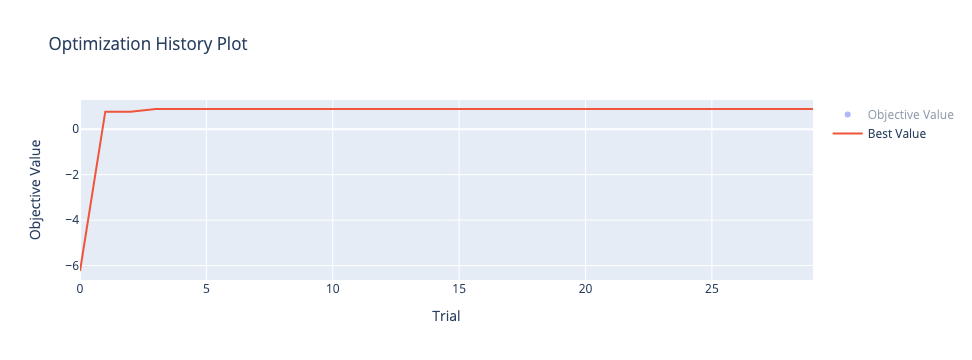

In [52]:
plot_optimization_history(study)

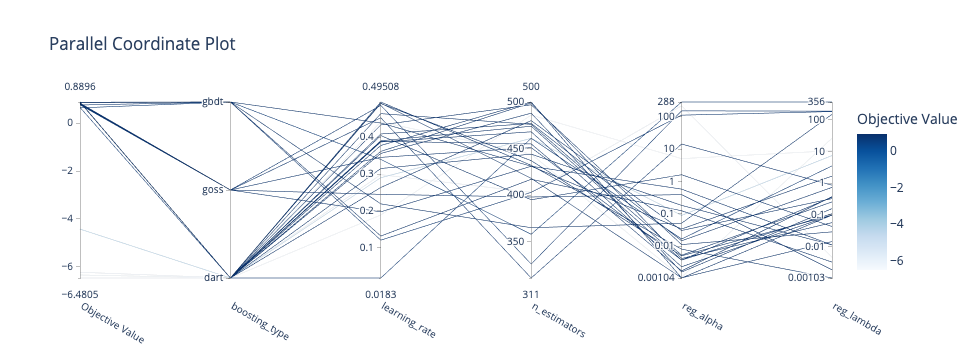

In [53]:
plot_parallel_coordinate(study)

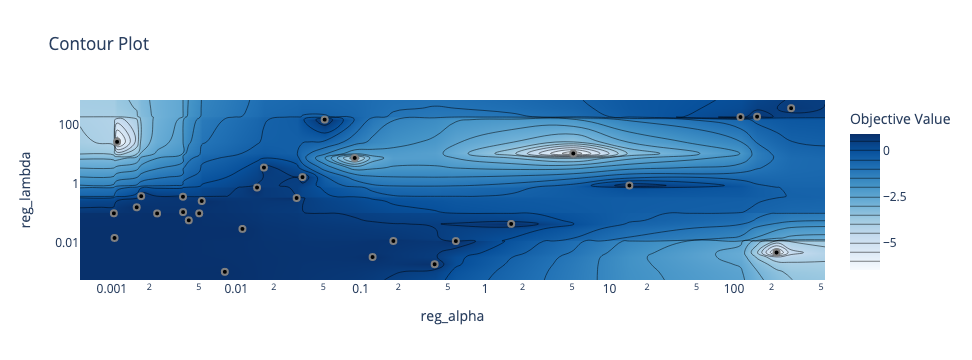

In [54]:
plot_contour(study, params=['reg_alpha', 'reg_lambda'])

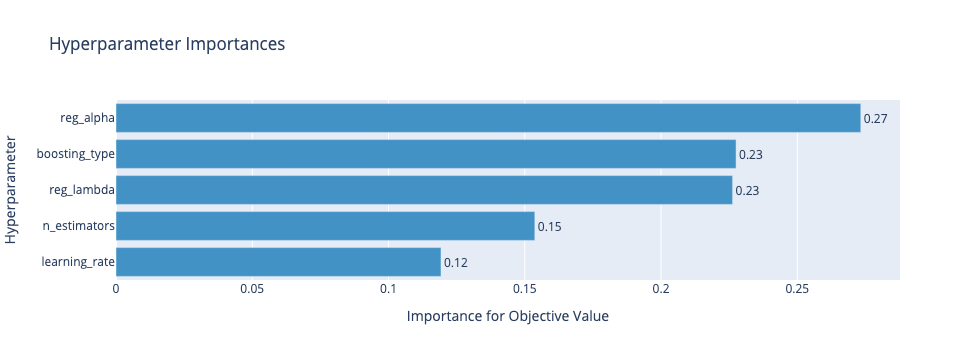

In [56]:
plot_param_importances(study)

In [57]:
study.best_params

{'n_estimators': 474,
 'learning_rate': 0.3899774853709844,
 'boosting_type': 'dart',
 'reg_alpha': 0.0037254257876981737,
 'reg_lambda': 0.3592637920855517}

## 5.2. Ray
[Ray] is a unified framework for scaling AI and Python applications. In this section, we are going to use [Ray Tune], a sub-module of Ray to implement various optimization algorithms. Tune wraps many other optimization libraries and organizes the algorithms into two groups, [searchers] and [schedulers], which are equivalent to *sampler* and *pruner* in Optuna.

[Ray]: https://github.com/ray-project/ray
[Ray Tune]: https://docs.ray.io/en/master/tune/index.html
[searchers]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
[schedulers]: https://docs.ray.io/en/latest/tune/api_docs/schedulers.html

### Optimizer wrappers
*Searchers*:
- <code style='font-size:13px'>[AxSearch]</code>, an implementation of Bayesian Optimization by Facebook's [Ax]
- <code style='font-size:13px'>[BayesOptSearch]</code>, an implementation of Bayesian Optimization by [bayes_opt]
- <code style='font-size:13px'>[TuneBOHB]</code>, an implementation of BOHB by [HpBandSter]
- <code style='font-size:13px'>[BlendSearch]</code> and <code style='font-size:13px'>[CFO]</code>, two optimizers by Microsoft's [FLAML]
- <code style='font-size:13px'>[DragonflySearch]</code>, an implementation of various optimizers by [DragonFly]
- <code style='font-size:13px'>[HEBOSearch]</code>, an implementation of [HEBO]
- <code style='font-size:13px'>[HyperOptSearch]</code>, an implementation of TPE by [hyperopt]
- <code style='font-size:13px'>[NevergradSearch]</code>, an implementation of Facebook's [NeverGrad]
- <code style='font-size:13px'>[ZOOptSearch]</code>, an implementation of ASRacos by [ZOOpt]

*Schedulers*:


[AxSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#ax-tune-search-ax-axsearch
[Ax]: https://github.com/facebook/Ax
[BayesOptSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#bayesian-optimization-tune-search-bayesopt-bayesoptsearch
[bayes_opt]: https://github.com/fmfn/BayesianOptimization
[TuneBOHB]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#bohb-tune-search-bohb-tunebohb
[HpBandSter]: https://github.com/automl/HpBandSter
[BlendSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#blendsearch-tune-search-flaml-blendsearch
[CFO]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#cfo-tune-search-flaml-cfo
[FLAML]: https://github.com/microsoft/FLAML/tree/main/flaml/tune
[DragonflySearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#dragonfly-tune-search-dragonfly-dragonflysearch
[DragonFly]: https://github.com/dragonfly/dragonfly
[HEBOSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#hebo-tune-search-hebo-hebosearch
[HEBO]: https://github.com/huawei-noah/HEBO
[HyperOptSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#hyperopt-tune-search-hyperopt-hyperoptsearch
[hyperopt]: https://hyperopt.github.io/hyperopt/
[NevergradSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#nevergrad-tune-search-nevergrad-nevergradsearch
[NeverGrad]: https://github.com/facebookresearch/nevergrad
[OptunaSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#optuna-tune-search-optuna-optunasearch
[Optuna]: https://optuna.org/
[ZOOptSearch]: https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#zoopt-tune-search-zoopt-zooptsearch
[ZOOpt]: https://github.com/polixir/ZOOpt

In [ ]:
import warnings; warnings.filterwarnings('ignore')
import logging
import numpy as np; np.set_printoptions(precision=4, suppress=True)
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import r2_score as R2
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import ray
# from ray.air import session
from ray import tune
from ray.tune.sklearn import TuneSearchCV
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.FATAL)

In [6]:
dfBoston = pd.read_csv('data/boston.csv')
dfBoston.head()

,crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
x = dfBoston.copy()
y = x.pop('price')
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/10, random_state=7)

### Ray Tuner
Ray run hyperparameters optimization via the class <code style='font-size:13px'>[Tuner]</code>. This class has 3 main components:
<code style='font-size:13px'>[Trainable]</code>
<code style='font-size:13px'>[TuneConfig]</code> and
<code style='font-size:13px'>[RunConfig]</code>.

[Tuner]: https://docs.ray.io/en/master/tune/api_docs/execution.html#tuner
[Trainable]: https://docs.ray.io/en/latest/tune/api_docs/trainable.html
[TuneConfig]: https://docs.ray.io/en/master/ray-air/package-ref.html#ray.tune.tune_config.TuneConfig
[RunConfig]: https://docs.ray.io/en/master/ray-air/package-ref.html#ray.air.config.RunConfig

In [9]:
def objective(paramSpace):
    algo = LGBMRegressor(**paramSpace, verbosity=-1)
    scoreValid = cross_val_score(algo, xTrain, yTrain, scoring='r2', cv=5).mean()
    return scoreValid

paramSpace = {
    'n_estimators': tune.randint(300, 500),
    'learning_rate': tune.uniform(0.01, 0.5),
    'boosting_type': tune.choice(['gbdt', 'goss', 'dart']),
    'reg_alpha': tune.loguniform(1e-3, 1e3, base=10),
    'reg_lambda': tune.loguniform(1e-3, 1e3, base=10),
    'subsample': tune.quniform(0.2, 0.8, q=0.1),
    'colsample_bytree': tune.quniform(0.2, 0.8, q=0.1),
    'num_leaves': tune.qlograndint(4, 64, q=2, base=2),
}

In [18]:
tuneConfig = tune.TuneConfig(
    # metric='binary_erorr',
    mode='max',
    scheduler='async_hyperband',
    num_samples=10,
)

runConfig = ray.air.config.RunConfig(verbose=0)

tuner = tune.Tuner(objective, param_space=paramSpace, tune_config=tuneConfig, run_config=runConfig)
result = tuner.fit()

In [28]:
result.get_best_result().metrics['_metric']

0.8808802735272714

In [25]:
result.get_best_result().log_dir

PosixPath('/Users/hungpq/ray_results/objective_2022-09-15_00-27-36/objective_87351_00004_4_boosting_type=dart,colsample_bytree=0.7000,learning_rate=0.2549,n_estimators=462,num_leaves=6,reg_alpha=0._2022-09-15_00-27-39')

In [24]:
result.get_best_result().config

{'n_estimators': 462,
 'learning_rate': 0.2549450865455335,
 'boosting_type': 'dart',
 'reg_alpha': 0.00620586579780976,
 'reg_lambda': 0.015631260583187825,
 'subsample': 0.5,
 'colsample_bytree': 0.7000000000000001,
 'num_leaves': 6}

### TuneSearchCV
Instead of defining experiments/trials explicitly, we can use <code style='font-size:13px'>[TuneSearchCV]</code>, a function using Scikit-learn's interface dedicated to tune Machine Learning algorithms. You can change the optimizer via the parameter <code style='font-size:13px'>search_optimization</code>, it accpets either a string (*random*, *bayesian*, *hyperopt*, *bohb* or *optuna*) or any Tune searcher.

[TuneSearchCV]: https://docs.ray.io/en/latest/tune/api_docs/sklearn.html#tunesearchcv

In [5]:
algo = LGBMRegressor(verbosity=-1)

paramSpace = {
    'n_estimators': tune.randint(300, 500),
    'learning_rate': tune.uniform(0.01, 0.5),
    'boosting_type': tune.choice(['gbdt', 'goss', 'dart']),
    'reg_alpha': tune.loguniform(1e-3, 1e3, base=10),
    'reg_lambda': tune.loguniform(1e-3, 1e3, base=10),
    'subsample': tune.quniform(0.2, 0.8, q=0.1),
    'colsample_bytree': tune.quniform(0.2, 0.8, q=0.1),
    'num_leaves': tune.qlograndint(4, 64, q=2, base=2),
}

In [29]:
validator = TuneSearchCV(
    estimator=algo,
    param_distributions=paramSpace,
    cv=ShuffleSplit(n_splits=1, test_size=0.2, random_state=7),
    n_trials=5,
    scoring='r2',
    search_optimization='hyperopt',
    early_stopping='ASHAScheduler',
    time_budget_s=300,
    mode='max',
    random_state=7,
)

In [30]:
validator.fit(xTrain, yTrain)

TuneSearchCV(cv=ShuffleSplit(n_splits=1, random_state=7, test_size=0.2, train_size=None),
             early_stopping='ASHAScheduler',
             estimator=LGBMRegressor(verbosity=-1), mode='max', n_jobs=-1,
             n_trials=5,
             param_distributions={'boosting_type': <ray.tune.search.sample.Categorical object at 0x00000232998B2AF0>,
                                  'colsample_bytree': <ray.tune.search.sample.Float object at 0x00000...
                                  'num_leaves': <ray.tune.search.sample.Integer object at 0x000002329964C280>,
                                  'reg_alpha': <ray.tune.search.sample.Float object at 0x00000232998B2B80>,
                                  'reg_lambda': <ray.tune.search.sample.Float object at 0x00000232998B2C40>,
                                  'subsample': <ray.tune.search.sample.Float object at 0x000002329964CF40>},
             random_state=7, scoring='r2', search_optimization='hyperopt',
             sk_n_jobs=1, time_budget_s=300)

In [31]:
validator.best_params_

{'n_estimators': 326,
 'learning_rate': 0.46439231091458705,
 'boosting_type': 'dart',
 'reg_alpha': 0.0010104257647162234,
 'reg_lambda': 0.17841255959079713,
 'subsample': 0.6000000000000001,
 'colsample_bytree': 0.4,
 'num_leaves': 52}

In [35]:
validator.best_score

0.8187092316296182

In [37]:
validator.best_estimator.score(xTest, yTest)

0.91666816614645

## 5.3. NNI

# References
- *papers.nips.cc - [Algorithms for hyperparameters optimization](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)*
- *arxiv.org - [Non-stochastic best arm identification and hyperparameter optimization](https://arxiv.org/pdf/1502.07943.pdf)*
- *arxiv.org - [Hyperband: Bandit-based configuration evaluation for hyperparameter optimization](https://arxiv.org/pdf/1603.06560.pdf)*
- *arxiv.org - [BOHB: Robust and efficient hyperparameter optimization at scale](https://arxiv.org/pdf/1807.01774.pdf)*
- *deepmind.com - [Population based training of Neural Networks](https://www.deepmind.com/blog/population-based-training-of-neural-networks)*
- *automl.org - [Overview of HPO packages](https://www.automl.org/automl/hpo-packages/)*
- *medium.com - [A conceptual explanation of Bayesian hyperparameter optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)*
- *medium.com - [Hyperparameter optimization algorithms: a short review](https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903)*
- *krasserm.github.io - [Bayesian Optimization](https://krasserm.github.io/2018/03/21/bayesian-optimization/)*
- *distill.pub - [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)*
- *borealisai.com - [Tutorial #8: Bayesian optimization](https://www.borealisai.com/research-blogs/tutorial-8-bayesian-optimization/)*
- *neupy.com - [Hyperparmeter optimization for Neural Networks](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html)*
- *ekamperi.github.io - [Acquisition functions](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)*
- *blog.ml.cmu.edu - [Massively parallel hyperparameter optimization](https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/)*

In [ ]:
pip install hpbandster ConfigSpace

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*